In [1]:
#importing dependencies
import keras
import cv2
import keras.backend as K
from keras.layers import Dense ,Conv2D ,MaxPooling2D ,Dropout ,Flatten ,Activation ,Multiply
from keras.activations import tanh
from keras.optimizers import Adam
import numpy as np
import tensorflow as tf
import os
from keras_efficientnets import EfficientNetB2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score ,recall_score ,f1_score ,roc_auc_score ,confusion_matrix
from keras.models import load_model ,Model

Using TensorFlow backend.


In [2]:
#defining function to load and proces the data from the directory
def load_and_process_data(parent_dir):
    classes = os.listdir(parent_dir)
    no_of_classes = len(classes)
    class_counter = 0
    file_counter = 0
    X_train = []
    Y_train = []
    for folder in classes:
        class_dir = os.path.join(parent_dir ,folder)
        print('class {} is {}'.format(class_counter ,folder))
        for file in os.listdir(class_dir):
            file_counter += 1 
            label = np.zeros([len(classes)])
            label[class_counter] = 1
            final_image = preprocess(os.path.join(class_dir ,file))
            X_train.append(final_image)
            Y_train.append(label)
        class_counter += 1
    print('Found {} images belonging to {} classes'.format(file_counter ,len(classes)))
    X_train = np.asarray(X_train)
    Y_train = np.asarray(Y_train)
    return X_train ,Y_train

In [3]:
#definging a preprocessing function
def preprocess(file):
    image = cv2.imread(file)
    if image is not None:
        image = cv2.resize(image ,(224,224))
        image = image/255
    else:
        print('No such {} exists'.format(file))
    return image

In [4]:
#focal loss for training
def myloss(alpha ,gamma):
    def focal_loss(y_true ,y_pred):
        y_pred = K.clip(y_pred ,1e-8 ,1-1e-8)
        log_lik = y_true*K.log(y_pred)
        loss = alpha*((1-y_pred)**gamma)*log_lik
        return -K.sum(loss)
    return focal_loss
focal_loss = myloss(2.0 ,1.5)

In [7]:
#pretrained efficient net trained on pneumonia cropped dataset(based on segmentation)
eff_net = load_model('eff_net_seg.h5' ,custom_objects={'focal_loss': focal_loss})

In [8]:
#defining attention mechanism
def attention_layer(flatten):
    activation = Activation(tanh ,name = 'myactivation')(flatten)
    activation = Dropout(0.2)(activation)
    softmax_layer = Dense(1408 ,activation = 'softmax')(activation)
    multiplied =  Multiply(name = 'manoj')([softmax_layer ,flatten])
    return multiplied

In [9]:
#setting all layers to trainable(can be ignored because ,by default everything will be trainable)
for layer in eff_net.layers:
    layer.trainable = True

In [10]:
#printing the efficient net summary
eff_net.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 32) 128         conv2d_20[0][0]                  
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 112, 112, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [11]:
#building ,compiling ,printing the summary
input_ = eff_net.output
print(tf.shape(input_))
#Conv_layer = Conv2D(2048 ,(3,3) ,kernel_initializer = 'glorot_uniform' ,activation = 'elu')(input_)
max_pool = MaxPooling2D((5 ,5))(input_)
flatten = Flatten()(max_pool)
attention_output = attention_layer(flatten)
final_softmax = Dense(3 ,activation = 'softmax')(attention_output)
model = Model(inputs = eff_net.input ,outputs = [final_softmax])
model.summary()
model.compile(loss = myloss(2.0 ,1.5) ,optimizer = Adam(lr = 0.000005) ,metrics = ['acc'])

Tensor("Shape:0", shape=(4,), dtype=int32)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 32) 128         conv2d_20[0][0]                  
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 112, 112, 32) 0           batch_normalization_1[0][0]      
_________________________________________________

In [13]:
#loading the data
train_dir = r'D:\COMPUTERS\AI\dataset_and_embeddings\covid-segmented-cropped\train'
valid_dir = r'D:\COMPUTERS\AI\dataset_and_embeddings\covid-segmented-cropped\valid'
test_dir = r'D:\COMPUTERS\AI\dataset_and_embeddings\covid-segmented-cropped\test'
X_train ,Y_train = load_and_process_data(train_dir)
X_test ,Y_test = load_and_process_data(test_dir)
X_valid ,Y_valid = load_and_process_data(valid_dir)

class 0 is covid
class 1 is healthy
class 2 is pneumonia
Found 583 images belonging to 3 classes
class 0 is covid
class 1 is healthy
class 2 is pneumonia
Found 42 images belonging to 3 classes
class 0 is covid
class 1 is healthy
class 2 is pneumonia
Found 31 images belonging to 3 classes


In [14]:
#training
history = model.fit(X_train ,
                    Y_train ,
                    epochs = 30 ,
                    batch_size = 8 ,
                    verbose = 1 ,
                    validation_data = (X_valid ,Y_valid))

Train on 583 samples, validate on 31 samples
Epoch 1/30
583/583 [==============================] - 129s 222ms/step - loss: 9.4242 - acc: 0.5043 - val_loss: 9.2981 - val_acc: 0.3548
Epoch 2/30
583/583 [==============================] - 55s 94ms/step - loss: 9.2012 - acc: 0.5815 - val_loss: 9.2979 - val_acc: 0.3226
Epoch 3/30
583/583 [==============================] - 55s 94ms/step - loss: 8.9004 - acc: 0.5918 - val_loss: 9.2981 - val_acc: 0.3226
Epoch 4/30
583/583 [==============================] - 55s 93ms/step - loss: 8.5419 - acc: 0.6261 - val_loss: 9.2974 - val_acc: 0.3226
Epoch 5/30
583/583 [==============================] - 54s 93ms/step - loss: 8.1451 - acc: 0.6432 - val_loss: 9.2983 - val_acc: 0.3548
Epoch 6/30
583/583 [==============================] - 55s 94ms/step - loss: 7.6763 - acc: 0.6690 - val_loss: 9.3164 - val_acc: 0.1935
Epoch 7/30
583/583 [==============================] - 55s 94ms/step - loss: 7.0913 - acc: 0.7256 - val_loss: 9.4551 - val_acc: 0.3226
Epoch 8/30
583/

In [15]:
model.evaluate(X_test ,Y_test)

42/42 [==============================] - 4s 89ms/step


[11.312696263903664, 0.8571428656578064]

In [16]:
#predicting
y_test_pred = model.predict(X_test)

In [17]:
#converting into classes
final_y_pred = []
final_y_true = []
for i in range(y_test_pred.shape[0]):
    k = np.argmax(y_test_pred[i])
    final_y_pred.append(k+1)
for i in range(Y_test.shape[0]):
    k = np.argmax(Y_test[i])
    final_y_true.append(k+1)

[[13  0  0]
 [ 5  9  0]
 [ 1  0 14]]


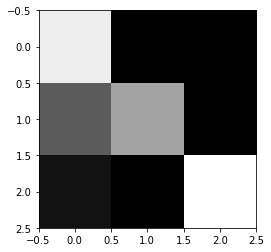

In [18]:
#confusion matrix
k = confusion_matrix(final_y_true ,final_y_pred)
print(k)
plt.imshow(k ,cmap = 'gray')

In [19]:
#acc_score ,pre_score ,recall ,f1
acc_score = accuracy_score(final_y_true ,final_y_pred)
pre_score = precision_score(final_y_true ,final_y_pred ,average = 'micro')
recall = recall_score(final_y_true ,final_y_pred ,average = 'micro')
f1 = f1_score(final_y_true ,final_y_pred ,average = 'micro')

print('accuracy score : {}'.format(acc_score))
print('precision score : {}'.format(pre_score))
print('recall score : {}'.format(recall))
print('f1 score : {}'.format(f1))


accuracy score : 0.8571428571428571
precision score : 0.8571428571428571
recall score : 0.8571428571428571
f1 score : 0.8571428571428571


In [20]:
#printing the model layers
model.layers

In [21]:
#defining grad cam function
def grad_cam(image, cls):
    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.layers[-8].output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (224 ,224), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

In [36]:
#computing gradcam map for random image
#directories can be adjusted
test_image_dir = os.path.join(r'D:\COMPUTERS\AI\dataset_and_embeddings\covid-segmented-cropped\test\healthy' ,'IM-0016-0001.jpeg')
image = preprocess(test_image_dir)
cam = grad_cam(image.reshape(1,224,224,3), cls=1)

In [37]:
#predicted class
np.argmax(model.predict(image.reshape(1,224,224,3)))

1

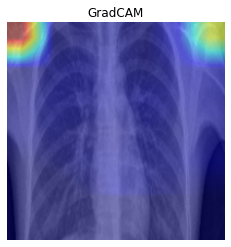

In [38]:
#plotting gradcam
plt.title('GradCAM')
plt.axis('off')
plt.imshow(cv2.resize(cv2.imread(test_image_dir),(224,244)))
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.show()

In [39]:
#saving model
model.save('eff_net_seg_fine_tuned.h5')